### MLP Weights for Feature Importance

The following code will extract the input weights on all of our data to find which one is most important from the classifier parameters that were determined to be the best.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, auc, roc_auc_score

In [2]:
# Read the cleaned data into a dataframe
X = pd.read_csv("../data/processed/X.csv")
y = pd.read_csv("../data/processed/Y.csv")

In [3]:
bestmlp = MLPClassifier(hidden_layer_sizes=(7,), activation='tanh', solver='adam', alpha=0.001, learning_rate = 'adaptive',
                       random_state=2020)
res = bestmlp.fit(X, y.values.ravel())

In [4]:
input_weight_df = pd.DataFrame()
for i in range(len(res.coefs_[0])):
    input_weight_df.loc[str(X.columns[i]),"Input Layer Weight"] = res.coefs_[0][i][0]

In [5]:
input_weight_df

,Input Layer Weight
current_status_Laboratory-confirmed case,0.457685
sex_Female,-0.069660
sex_Male,-0.165934
age_group_0 - 9 Years,-0.570429
age_group_10 - 19 Years,-0.815546
age_group_20 - 29 Years,-0.679447
age_group_30 - 39 Years,-0.436577
age_group_40 - 49 Years,-0.447137
age_group_50 - 59 Years,-0.152431
age_group_60 - 69 Years,0.024489


In [6]:
input_weight_df.index = ['Lab-confirmed case', 'Female', 'Male',\
       '0 - 9 Years', '10 - 19 Years',\
       '20 - 29 Years', '30 - 39 Years',\
       '40 - 49 Years', '50 - 59 Years',\
       '60 - 69 Years', '70 - 79 Years',\
       '80+ Years',\
       'American Indn./AK Nat.',\
       'Asian',\
       'Black',\
       'Hispanic/Latino',\
       'Multiple/Other',\
       'Nat. HI/Other Pac. Isl.',\
       'White', 'Hosp_No',\
       'Hosp_Yes', 'ICU_No', 'ICU_Yes', 'Medcond_No',\
       'Medcond_Yes']


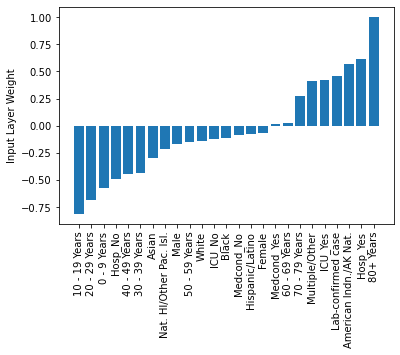

<Figure size 432x288 with 0 Axes>

In [7]:
input_weight_df = input_weight_df.sort_values('Input Layer Weight')
plt.bar(input_weight_df.index, input_weight_df.loc[:,'Input Layer Weight'], ecolor='black', align='center')
plt.ylabel('Input Layer Weight')
plt.xticks(rotation=90)
plt.show()
plt.savefig('../plots/MLP_ILayerWeights')

### MLP Kfold

In [8]:
kf = KFold(5)

i=1
dfa = pd.DataFrame()

aucs = []
for trainIndex, textIndex in kf.split(X):
    xTrain, xTest = X.iloc[trainIndex], X.iloc[textIndex]
    yTrain, yTest = y.iloc[trainIndex], y.iloc[textIndex]
    
    #Fitting MLP
    bestmlp = MLPClassifier(hidden_layer_sizes=(7,), activation='tanh', solver='adam', alpha=0.001, learning_rate = 'adaptive')
    res = bestmlp.fit(xTrain, yTrain.values.ravel())
    ypred = res.predict(xTest)
    
    #Finding aucs
    aucs.append(roc_auc_score(yTest, ypred))
    #Classification df
    rpt = pd.DataFrame(classification_report(yTest, ypred,  output_dict=True)).transpose()
    rpt['Fold'] = i
    dfa = dfa.append(rpt)
    
    i += 1

In [9]:
meandf_c = dfa.groupby(dfa.index).mean()
sddf_c = dfa.groupby(dfa.index).std()
dfa


resdf_c = round(meandf_c.loc[:,'precision':'support'],4).astype(str)+ " ± "+\
round(sddf_c.loc[:,'precision':'support'],4).astype(str)
resdf_c

,precision,recall,f1-score,support
0,0.9549 ± 0.0334,0.9754 ± 0.0245,0.965 ± 0.0287,60405.0 ± 4117.8777
1,0.649 ± 0.0518,0.4442 ± 0.1219,0.5196 ± 0.1048,5390.4 ± 4117.7196
accuracy,0.9377 ± 0.0472,0.9377 ± 0.0472,0.9377 ± 0.0472,0.9377 ± 0.0472
macro avg,0.8019 ± 0.0259,0.7098 ± 0.0534,0.7423 ± 0.0441,65795.4 ± 0.5477
weighted avg,0.9323 ± 0.049,0.9377 ± 0.0472,0.9338 ± 0.0482,65795.4 ± 0.5477


In [10]:
f1s = []
precisions = []
recalls = []
accuracys = []
for fold in dfa['Fold'].unique():
    f1df = dfa.loc[dfa['Fold']==fold]
    f1s.append(f1df.loc['macro avg', 'f1-score'])
    precisions.append(f1df.loc['macro avg', 'precision'])
    recalls.append(f1df.loc['macro avg', 'recall'])
    accuracys.append(f1df.loc['accuracy', 'recall'])

In [11]:
print('F1 Scores: ' + str(round(np.mean(f1s),4)) + ' ± ' + str(round(np.std(f1s), 4)))
print('Precision: ' + str(round(np.mean(precisions),4)) + ' ± ' + str(round(np.std(precisions), 4)))
print('Recall: ' + str(round(np.mean(recalls),4)) + ' ± ' + str(round(np.std(recalls), 4)))
print('Accuracy: ' + str(round(np.mean(accuracys),4)) + ' ± ' + str(round(np.std(accuracys), 4)))

F1 Scores: 0.7423 ± 0.0394
Precision: 0.8019 ± 0.0231
Recall: 0.7098 ± 0.0478
Accuracy: 0.9377 ± 0.0422


In [12]:
print('AUC = '+ str(round(np.mean(aucs), 4)) + ' ± '+ str(round(np.std(aucs), 4)))

AUC = 0.7098 ± 0.0478
